In [1]:
%config InlineBackend.figure_format = 'svg'
from IPython.display import Video, Image, HTML
import jax
import jax.numpy as jnp
import numpy as np
import scipy
import gzip
import pickle
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['figure.figsize'] = (9, 6)
matplotlib.rcParams['image.cmap'] = 'summer'
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['legend.fontsize'] = 'large'
matplotlib.rcParams['figure.titlesize'] = 'medium'
matplotlib.rcParams['lines.linewidth'] = 2.0
import matplotlib.pyplot as plt
from celluloid import Camera

##### Machine Learning and Applications - SVM and kernel machines

### David Picard 
### École des Ponts ParisTech
### david.picard@enpc.fr

# Binary Linear Classification

Let us tackle the simplest classification problem there is by considering a linear predictor that has to distinguish $d$ dimensional vectors into 2 classes.



- Input $\mathbf{x} \in \mathbb{R}^d$
- Output $y \in \{-1; 1\}$    

Linear prediction function
$$f(\mathbf{x}) = \text{sign}(\langle \mathbf{w}, \mathbf{x}\rangle +b) $$

Defines a hyperplane
- Normal vector $\mathbf{w}$
- Bias (offset) $b$


In [2]:
w = jnp.ones(2)
b = -0.5

t = 40; tx = jnp.linspace(-1, 2, t); ty = jnp.linspace(-1, 2, t)
xv, yv = jnp.meshgrid(tx, ty, sparse=True); xv = xv.squeeze(); yv = yv.squeeze()
xx = jnp.array([[xx, yy] for yy in yv for xx in xv])
levels=jnp.linspace(-1.5, 1.5, 10)
y_pred = (1.*(jnp.matmul(xx, w)+b > 0)).reshape(t, t)
plt.contourf(xv, yv, -y_pred, levels=levels);

This linear classifier can be obtained by optimizing a classification loss over a set of training pairs.

## ERM

Hinge loss:

$$ l(y, f(\mathbf{x})) = \max(0, 1 - yf(\mathbf{x})) $$

Given training set $\mathcal{A} = \{(\mathbf{x}, y)\}$, minimize the empirical risk:
$$\min_{\mathbf{w}, b} \frac{1}{n}\sum_i max(0, 1 - y_i (\langle\mathbf{w}, \mathbf{x}\rangle + b)) $$

Convex problem (sum of convex) easy optimization by gradient descent

For large training sets, stochastic gradient descent works great

## MNIST

5


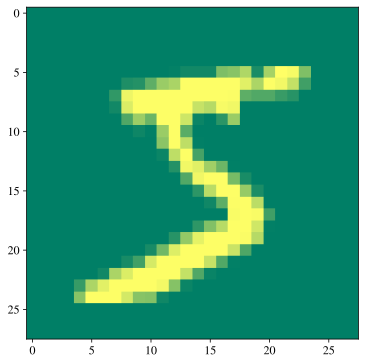

In [3]:
# Load the dataset
data = np.load('mnist.npz')
X = data['X_train']
y = data['y_train']
plt.imshow(X[0,:].reshape(28,28))
print(y[0])

In [4]:
X = data['X_train_bin']
y = data['y_train_bin']*2-1

def func(w, b, x):
    return jnp.matmul(x, w) + b

def hinge(w, b, x, y):
    return jax.nn.relu(1 - y * func(w, b, x)).mean()

@jax.jit
def update(w, b, x, y):
    dw, db = jax.grad(hinge, argnums=(0,1))(w, b, x, y)
    return w - 0.01*dw, b - 0.01*db

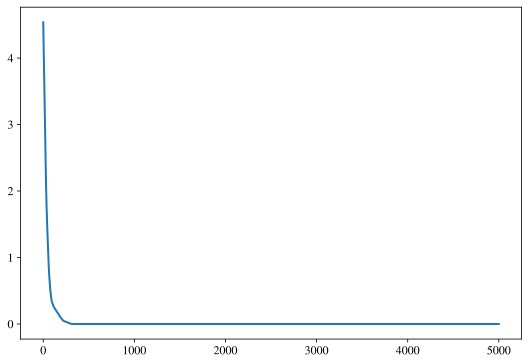

In [5]:
w = np.random.randn(784)
b = 0.

loss = []
for t in range(5000):
    loss.append(hinge(w, b, X, y))
    w, b = update(w, b, X, y)
plt.plot(loss)

In [6]:
def accuracy(y_pred, y_true):
    return jnp.sign(y_true*y_pred).mean()

y_pred = func(w, b, X)
print('accuracy: {}'.format(accuracy(y_pred, y)))

accuracy: 1.0


In [7]:
X_val = data['X_val_bin']
y_val = data['y_val_bin']*2-1

y_pred = func(w, b, X_val)
print('validation accuracy: {}'.format(accuracy(y_pred, y_val)))

validation accuracy: 0.9047619104385376


## Equivalent solutions

In [8]:
w = jnp.array([-1, 1]) + 0.1*np.random.randn(5, 2)

plt.scatter([0, 1], [0, 1], c=[0, 1])
for i in range(5):
    plt.plot([0, 1], [w[i,1], w[i,0]+w[i,1]])

## Complexity impacts generalization


![complexity.pdf.png](complexity.pdf.png)

Similarly to how we used regularization in regression to avoid having our function take absurd values outside of the training samples, we here want to enforce some regularity in our function to prevent having boundaries between classes with a complexe geometry that cannot be infered from the training data. The key idea is that the boundary should not be more _complex_ than the data that was used to create it in the first place. Doing differently would be equivalent to hallucinating structure where there was none that we could observe. Of course, it all depends on the definition of _complex_, but this leads us to a great design choice which is to prefer _less complex_ solutions when possible.

## Structural Risk Minimization

The Structural Risk Minimization principle defines a trade-off between the quality of the approximation of the given data and the complexity of the approximating function (see <cite data-cite="vapnik1995nature">(Vapnik, 1995)</cite>)

![vapnik](vapnik.jpg)

## SRM selection principle

Given a family of functions that all have $R_e = 0$ and that can be split into subsets $S_k$ ordered by their complexity $h_k$

$$ S_0 \subset S_1 \subset \dots \subset S_N $$

$$ h_0 \leq h_1 \leq \dots \leq h_N $$

We choose the functions with the lowest complexity

This is a machine learning of Occam's razor: among all possible explanations, the simplest is the best. Instead of explanations, we want to approximate a results, so among all functions that make similar approximation errors, we chose the simplest as measured by their complexity $h_k$.

## Measuring complexity - VC Dimension

The VC Dimension of a set of indicator functions $Q(z, \alpha), \alpha \in \Lambda$, is the maximum number $h$ of vectors $z_1, \dots , z_h$ that can be separated into 2 classes in all $2^h$ possible ways using functions from the set.


The VC dimension is a measure of complexity, and the nice thing about it is that it is solely defined in terms of data and not in terms of structural properties, etc. It is also very intuitive: the higher the number of points that could be perfectly classified however their labels, the more complex the function. The main drawback of VC is that it is very hard to estimate for functions that are not super simple. Also, it is a very crude measurement of the complexity.

## Exercises

- What is the VC Dimension of linear functions in the 2D plane?
- What is the VC Dimension of axis-aligned rectangles in the 2D plane?

## Risk Bound

True risk is bounded by a combination of empirical risk and structural risk depending on $h$ (full results in <cite data-cite="vapnik1995nature">(Vapnik, 1995)</cite>)

$$ R(\alpha) \leq R_e(\alpha) + F(h) $$


![struct](struct.pdf.png)

## Large margin


Let $\mathbf{w}$ be the separating hyperplane with margin $\Delta$ : 

\begin{equation}
y = \left\{ \begin{array}{rl}
1 & \text{if } \mathbf{w}^\top x -b \geq \Delta, \\
-1 & \text{if } \mathbf{w}^\top x -b \leq -\Delta.
\end{array} \right.
\end{equation}

Theorem (Vapnik 1995): Given a training set $\mathcal{A} = \{(\mathbf{x}_i\in \mathbb{R}^d, y_i)\}$ such that $\|\mathbf{x}_i\|\leq R$ and that can be separated by an hyperplane with margin $\Delta$,

\begin{equation}
h \leq \min\left(\frac{R^2}{\Delta^2}, d\right)+1
\end{equation}

$\Rightarrow$ We have to maximize the margin


## $\ell_2$ norm

$\Rightarrow$ we have to minimize $||w||^2$

![margin](margin.png)


This is fairly intuitive: we want the decision boundary to be as far as possible from the training samples because near these training samples, we assume the class is more likely to be that of the nearby sample, and thus not changing.

# Support Vector Machines
$$
\begin{aligned}
	\min_{\mathbf{w}, b}&\quad \frac{1}{2} \|\mathbf{w}\|^2 \\
	\text{s.t.} &\quad \forall i, y_i(\langle\mathbf{w}, \mathbf{x}_i \rangle +b) \geq 1
\end{aligned}
$$

Of all the hyperplane that perfectly classify the training sample, select the one with minimal norm, see <cite data-cite="boser1992training">(Boser et al, 1992)</cite>.

## Soft Margin

In practice, define a soft margin
$$
\begin{aligned}
	\min_{\mathbf{w}, b, \zeta_i}&\quad \frac{\lambda}{2}\|\mathbf{w}\|^2 + \frac{1}{n}\sum_i \zeta_i \\
	\text{s.t.} & \quad \forall i, y_i(\mathbf{w}^\top\mathbf{x}_i +b)	\geq 1 - \zeta_i
\end{aligned}
$$

Solve the equivalent problem using stochastic gradient descent
$$
\begin{aligned}
	\min_{\mathbf{w}, b}&\quad \frac{\lambda}{2}\|\mathbf{w}\|^2 + \frac{1}{n}\sum_i	\max (0, 1 - y_i(\mathbf{w}^\top\mathbf{x} +b))
\end{aligned}
$$

Strongly convex problem


The soft margin problem was introduced in <cite data-cite="cortes1995support">(Cortes et al, 1995)</cite>. It is the most common and practical way to formulate the SVM problem as it is unlikely that our training set can be linearly separated to begin with.

## MNIST Cont.

In [9]:
def func(w, b, x):
    return jnp.matmul(x, w) + b

def hinge(w, b, x, y):
    return jax.nn.relu(1 - y * func(w, b, x)).mean()

def loss(w, b, x, y):
    return 0.0001*(w*w).sum() + hinge(w, b, x, y)

@jax.jit
def update(w, b, x, y):
    dw, db = jax.grad(loss, argnums=(0,1))(w, b, x, y)
    return w - 0.1*dw, b - 0.01*db

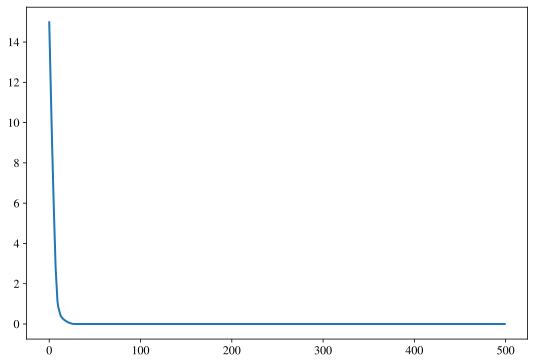

In [10]:
w = np.random.randn(784)
b = 0.

l = []
for t in range(500):
    l.append(hinge(w, b, X, y))
    w, b = update(w, b, X, y)
plt.plot(l)

In [11]:
def accuracy(y_pred, y_true):
    return jnp.sign(y_true*y_pred).mean()

y_pred = func(w, b, X)
print('accuracy: {}'.format(accuracy(y_pred, y)))

accuracy: 1.0


In [12]:
y_pred = func(w, b, X_val)
print('validation accuracy: {}'.format(accuracy(y_pred, y_val)))

validation accuracy: 0.4285714328289032


## Multiple classes

2 types of approaches for handling $M$ classes 

- One versus All: $M$ classifiers, take the $\text{argmax}$

- One versus One: $M(M-1)/2$ classifiers, majority vote


## MNIST

One versus all

In [13]:
X = data['X_train']
y = jax.nn.one_hot(data['y_train'], 10)*2 - 1

def func(w, b, x):
    return jnp.matmul(x, w) + b

def hinge(w, b, x, y):
    return jax.nn.relu(1 - y * func(w, b, x)).mean()

def loss(w, b, x, y):
    return 0.01*(w*w).sum() + hinge(w, b, x, y)

@jax.jit
def update(w, b, x, y):
    dw, db = jax.grad(loss, argnums=(0,1))(w, b, x, y)
    return w - 0.1*dw, b - 0.1*db

In [14]:
w = np.random.randn(784, 10)
b = jnp.zeros(10)

l = []
for t in range(2500):
    l.append(hinge(w, b, X, y))
    w, b = update(w, b, X, y)
plt.plot(l)

In [15]:
def accuracy(y_pred, y_true):
    return (1.*(jnp.argmax(y_true, axis=1) == jnp.argmax(y_pred, axis=1))).mean()

y_pred = func(w, b, X)
print('accuracy: {}'.format(accuracy(y_pred, y)))

accuracy: 1.0


In [16]:
X_val = data['X_val']
y_val = jax.nn.one_hot(data['y_val'], 10)*2 - 1

y_pred = func(w, b, X_val)
print('validation accuracy: {}'.format(accuracy(y_pred, y_val)))

validation accuracy: 0.6499999761581421


## Dual Problem
Back to the hard margin:
$$
\begin{aligned}
	\min_{\mathbf{w}, b}&\quad \frac{1}{2} \|\mathbf{w}\|^2 \\
	\text{s.t.} &\quad \forall i, y_i(\langle\mathbf{w}, \mathbf{x}_i \rangle +b) \geq 1
\end{aligned}
$$

Compute the Lagrangian:
$$
\begin{aligned}
	\mathcal{L}(\mathbf{w}, b, \alpha)& \quad = \frac{1}{2}\|\mathbf{w}\|^2 - \sum_i \alpha_i(y_i(\mathbf{w}^\top\mathbf{x_i}+b) - 1) \\
	\text{s.t.} & \quad \forall i, \alpha_i \geq 0
\end{aligned}
$$

$\alpha_i$ are the Lagrange multipliers for the augmented problem

## KKT Conditions


Karush-Kuhn-Tucker optimal conditions (well known in optimization):

- Stationarity: $\frac{\partial\mathcal{L}}{\partial\mathbf{w^\star}} = \mathbf{0}$

- Primal feasibility: $\forall i,  y_i(\mathbf{w}^\top\mathbf{x}_i +b) \geq 1$ 

- Dual feasibility: $\forall i, \alpha_i \geq 0$

- Complementary slackness: $\forall i, \alpha_i(y_i(\mathbf{w}^\top\mathbf{x_i}+b)-1)=0$



## Support vectors 

$$
\frac{\partial \mathcal{L}}{\partial\mathbf{w^\star}} =\mathbf{w^\star}  - \sum_i \alpha_i y_i \mathbf{x}_i
$$

$$
\begin{aligned}
	\mathbf{w^\star}  - \sum_i \alpha_i y_i \mathbf{x}_i = 0 \\
	\mathbf{w^\star} = \sum_i \alpha_i y_i \mathbf{x}_i
\end{aligned}
$$
$\mathbf{w}^\star$ is a linear combination of the training samples

## Representer theorem

Theorem (See <cite data-cite="scholkopf2002learning">(Schölkopf et al, 2002)</cite>): Let a training set $\mathcal{A} = \{(\mathbf{x}_i, y_i)\}$, an arbitrary error measuring function $l(\cdot, \cdot)$ and a stricly increasing function $g$, then any minimizer of the empirical risk

$$\mathbf{w}^\star = \text{argmin}_\mathbf{w} \frac{1}{n}\sum_i l(y_i, \langle \mathbf{w}, \mathbf{x}_i \rangle) + g(\|\mathbf{w}\|) $$

has a decomposition of the form

$$\mathbf{w}^\star = \sum_i \alpha_i \mathbf{x}_i $$

(The training set is a spanning set of the solution space)

## Support Vectors cont.

Complementary slackness: 

$$
	\forall i, \alpha_i(y_i(\mathbf{w}^\top\mathbf{x_i}+b) - 1)=0
$$

Which means
$$
	\mathbf{w}^\top\mathbf{x_i}+b \neq y_i \Rightarrow \alpha_i = 0
$$

$\mathbf{w}^\star$ is a combination of the samples that are **on** the margin

![sv](sv.png)

## Dual problem

Solving the dual problem:
$$
	\max_{\alpha} \inf_{\mathbf{w}, b} \mathcal{L}(\mathbf{w}, b, \alpha)
$$




Since $\mathbf{w} = \sum_i \alpha_i y_i \mathbf{x}_i$

$$
	\inf_{\mathbf{w}, b} \mathcal{L}(\mathbf{w}, b, \alpha) = \sum_i \alpha_i  - \frac{1}{2} \sum_{i,j}\alpha_i \alpha_j y_i y_j \mathbf{x}_i^\top\mathbf{x}_j
$$

$$
\max_\alpha D(\alpha) = \sum_i \alpha_i - \frac{1}{2} \sum_{i,j}\alpha_i \alpha_j y_i y_j \mathbf{x}_i^\top\mathbf{x}_j
$$

# Kernels

- Remark that $D(\alpha)$ does not depend on $\mathbf{x}$ but only on $\langle \mathbf{x}_i, \mathbf{x}_j \rangle$
- We can map $\mathbf{x}$ to a higher dimensional space using a non-linear mapping $\phi(\mathbf{x})$ (increase $h$)
- **Kernel trick**: we do not need to explicit $\phi$, only $k(\mathbf{x}_i, \mathbf{x}_j) = \langle \phi(\mathbf{x}_i), \phi(\mathbf{x}_j) \rangle$


$k(\mathbf{x}_i, \mathbf{x}_j)$ is called a **kernel** and defines the **similarity** between $\mathbf{x}_i$ and $\mathbf{x}_j$



## Kernel map


![map](map.jpg)

## Kernel SVM

Dual problem:
$$
	\max_\alpha D(\alpha) = \sum_i\alpha_i - \frac{1}{2} \sum_{i,j} \alpha_i \alpha_j y_i y_j k(\mathbf{x}_i, \mathbf{x}_j)
$$

Or in matrix form:
$$
	\max_\alpha D(\alpha) = \alpha^\top \mathbf{1} - \frac{1}{2} (\alpha \circ \mathbf{y})^\top \mathbf{K} (\alpha \circ \mathbf{y})
$$

With $\circ$ the Hadamard (element wise) product, and $\mathbf{K}$ the Gram matrix of the kernel

The kernelized version was already in the original <cite data-cite="boser1992training">(Boser et al, 1992)</cite> paper, although no good software were available at the time to efficiently solve the corresponding quadratic problem.

## Kernels

- Explicit: $k(x_i, x_j) = \langle \phi(x_i) \phi(x_j) \rangle$
- Implicit: Symmetric positive definite function ($\forall \alpha_i, \forall\alpha_j, \sum_{ij}\alpha_i\alpha_jk(x_i, x_j) \geq 0$) is a kernel

Examples:

- Linear: $k(\mathbf{x}_i, \mathbf{x}_j) = \langle \mathbf{x}_i, \mathbf{x}_j \rangle$
- Polynomial: $k(\mathbf{x}_i, \mathbf{x}_j) = \langle \mathbf{x}_i, \mathbf{x}_j \rangle^p$ or $k(\mathbf{x}_i, \mathbf{x}_j) = (1+\langle \mathbf{x}_i, \mathbf{x}_j \rangle )^p$
- Gaussian: $k(\mathbf{x}_i, \mathbf{x}_j) = e^{-\gamma\| \mathbf{x}_i- \mathbf{x}_j \|^2}$

## Exercise

Show that the polynomial kernel and the Gaussian kernel are indeed kernels

## Soft margin

Problem non linearly separable in the mapped space

$$
\begin{aligned}
	\min_{\mathbf{w}, b}&\quad \frac{1}{2}\|\mathbf{w}\|^2 + C\sum_i \zeta_i \\
	\text{s.t.} & \quad \forall i, y_i(\mathbf{w}^\top\mathbf{x} +b)	\geq 1 - \zeta_i \\
	& \quad \forall i, \zeta_i \geq 0
\end{aligned}
$$

Compute Lagrangian:

$$
\begin{aligned}
	\mathcal{L} =& \frac{1}{2}\|\mathbf{w}\|^2 + C\sum_i \zeta_i - \sum_i \mu_i \zeta_i - \sum_i \alpha_i(y_i(\mathbf{w}^\top\mathbf{x}_i +b) -1 + \zeta_i )\\
	\text{s.t.} & \forall i, \alpha_i \geq 0, \mu_i \geq 0
\end{aligned}
$$

## KKT

Stationarity:
$$
	\frac{\partial \mathcal{L}}{\partial\mathbf{w}} = \mathbf{w} - \sum_i \alpha_i y_i \mathbf{x}_i
$$
$\Rightarrow \mathbf{w}^\star = \sum_i \alpha_i y_i \mathbf{x}_i$
$$
	\frac{\partial \mathcal{L}}{\partial\zeta_i} = C - \mu_i - \alpha_i
$$
$\Rightarrow C = \alpha_i + \mu_i \Rightarrow 0 \leq \alpha_i \leq C$

$$
	\frac{\partial \mathcal{L}}{\partial b}  = \sum_i \alpha_i y_i \Rightarrow \sum_i\alpha_i y_i = 0
$$

## Kernel SVM
$$
\begin{aligned}
	\max_\alpha D(\alpha) &= \quad \sum_i \alpha_i - \frac{1}{2} \sum_{i,j} \alpha_i \alpha_j y_i y_j k(\mathbf{x}_i, \mathbf{x_j}) \\
	 \text{s.t.} & \quad \forall i, 0 \leq \alpha_i \leq C, \sum_i\alpha_i y_i = 0 
\end{aligned}
$$

Similar to the hard margin problem but with upper bound on the Lagrange multipliers (a training sample can not contribute more than $C$)

Decision function:
$$
	f(\mathbf{x}) = \sum_i \alpha_i y_i k(\mathbf{x}, \mathbf{x_i}) + b
$$

bias $b$ is annoying because of $\sum \alpha_iy_i = 0$

## K-SVM algorithm (SDCA)

Stochastic Dual Coordinate Ascent <cite data-cite="shalev2013stochastic">(Shalev-Shwartz et al, 2013)</cite>

1. Initialize $\alpha = \mathbf{0}$
2. Pick random sample $\mathbf{x}_i$
3. Compute $z_i = y_i\sum_j\alpha_j y_j k(\mathbf{x}_i, \mathbf{x_j})$
4. Update $\alpha_i \leftarrow \alpha_i + (1 - z_i)/k(\mathbf{x}_i, \mathbf{x}_i)$
5. Clip $\alpha_i \leftarrow \max(0, \min(C, \alpha_i))$
6. Goto 2


Second order ascent using diagonal Hessian approximation


## Toy test

In [17]:
def GaussKernel(x1, x2, gamma=10.0):
    return jnp.exp(-gamma*( jnp.linalg.norm(x1, axis=-1, keepdims=True)**2 + jnp.linalg.norm(x2, axis=-1, keepdims=True).T**2 - 2*jnp.dot(x1, x2.T)))

In [18]:
def SDCAupdate(i, alpha, x, y, K, C=1.0, eps=1e-7):
    y_pred = jnp.dot(K, alpha)
    err = 1 - y[i]*y_pred[i]
    if jnp.abs(err) < eps:
        return alpha[i]
    da = err/K[i,i]
    ai = y[i] * jnp.maximum(0, jnp.minimum(C, da+y[i]*alpha[i]))
    return ai

In [19]:
def f_pred(x, alpha, x_train, gamma=10.0):
    K = GaussKernel(x, x_train, gamma)
    return jnp.dot(K, alpha)

In [20]:
def f_true(x):
    if x <= 0.25: return -1.
    if x < 0.25 and x <= 0.5: return 1.
    if x > 0.5 and x <= 0.75: return -1.
    return 1.

In [21]:
n = 20
gamma = 100.0

In [22]:
key = jax.random.PRNGKey(42)
x = jax.random.uniform(key, (n,1))
y = [f_true(xi) for xi in x]

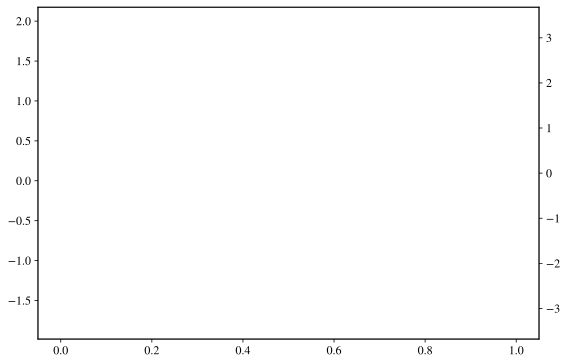

In [23]:
alpha = jnp.zeros((n,1))
K = GaussKernel(x,x, gamma)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
camera = Camera(fig)
t = jnp.arange(51)/50.

for e in range(10):
    r = jax.random.permutation(key, n)
    for i in r:
        ai = SDCAupdate(i, alpha, x, y, K, C=100.)
        alpha = alpha.at[i].set(ai)
        ax1.plot(t, [f_true(i) for i in t], '-k')
        y_pred = f_pred(t[:,None], alpha, x, gamma)
        ax1.plot(t, y_pred, '-r')
        ax2.stem(x, alpha, basefmt=" ")
        camera.snap()
        
animation = camera.animate()
HTML(animation.to_html5_video())

## Exercise

Knowing that the VC dimension of a linear classifier in $\mathbb{R}^d$ is $d+1$, 
- What is the VC dimension of a kernel SVM using  $k(\mathbf{x}_i, \mathbf{x}_j) = \langle \mathbf{x}_i, \mathbf{x}_j \rangle^2$?
	
- What is the VC dimension of a kernel SVM using  $k(\mathbf{x}_i, \mathbf{x}_j) = exp(-\gamma \| \mathbf{x}_i - \mathbf{x}_j \|^2)$?


## Reproducing Kernel Hilbert Space

A RKHS is a space $\mathcal{H}$ of functions $f: \mathcal{X} \rightarrow \mathbb{R}$ for which the pointwise evaluation corresponds to the dot product with specific functions

$$ f(x) = \langle f, \phi_x \rangle $$

Since $\phi_x \in \mathcal{H}$, we have

$$ \phi_x(y) = \langle \phi_x, \phi_y \rangle  = k(x, y)$$




The theory of RKHS can be a bit overwhelming, especially the original material, but a very good overview can be found in <cite data-cite="rakotomamonjy2005frames">(Rakotomamonjy et al, 2005)</cite>.

## Representer theorem

Theorem (simplified from <cite data-cite="scholkopf2002learning">(Schölkopf et al, 2002)</cite>): Let a training set $\mathcal{A} = \{(\mathbf{x}_i, y_i)\}$, $\mathcal{H}$ a Hilbert space of function associated with reproducing kernel $k$, an arbitrary error measuring function $l(\cdot, \cdot)$ and a stricly increasing function $g$, then any minimizer $f\in \mathcal{H}$ of the empirical risk

$$f^\star = \text{argmin}_{f\in \mathcal{H}} \frac{1}{n}\sum_i l(y_i, f(\mathbf{x}_i)) + g(\|\mathbf{f}\|_\mathcal{H}) $$

has a decomposition of the form

$$f^\star = \sum_i \alpha_i k(\mathbf{x}_i, \cdot) $$

(The training set is a spanning set of the solution space)

## Kernel approximation

Find an explicit mapping that approximate the kernel

$$ k(\mathbf{x}_i, \mathbf{x}_j) \approx \langle \phi(\mathbf{x}_i), \phi(\mathbf{x}_j) \rangle $$

Map the training set

$$ \forall i, \bar{\mathbf{x}_i} = \phi(\mathbf{x_i}) $$



Train a linear SVM on mapped samples

$$
	\min_{\mathbf{w}, b}\quad \frac{\lambda}{2}\|\mathbf{w}\|^2 + \frac{1}{n}\sum_i	\max (0, 1 - y_i(\mathbf{w}^\top\bar{\mathbf{x}} +b))
$$

Prediction function

$$ f(\mathbf{x}) = \langle \mathbf{w}, \phi(\mathbf{x})\rangle +b $$

## Nyström approximation <cite data-cite="williams2000using">(Williams et al, 2000)</cite>

Kernel matrix of the training set

$$ \mathbf{K} = [k(\mathbf{x}_i, \mathbf{x}_j)]_{ij} $$

Low rank approximation

$$ \mathbf{K} = \mathbf{ULU}^\top $$

Non linear projection

$$ \phi(\mathbf{x}) = \mathbf{L}_m^{-1/2}\mathbf{U}_m^\top\mathbf{K}(x), \quad \mathbf{K}(x) = [k(\mathbf{x}_i, \mathbf{x})]_i $$

Limits the VC dimension to m

There are many more kernel approximation methods, such as Random Fourier Features (see <cite data-cite="yang2012nystrom">(Yang et al, 2012)</cite>) or Taylor expansion based (Random MacLaurin), but in practice Nyström is very effective and always a good start.

## MNIST

In [24]:
def SquareKernel(X1, X2):
    return jnp.matmul(X1, X2.T)**2

In [25]:
X = data['X_train']
X = X/jnp.linalg.norm(X, axis=1)[:,None]
y = jax.nn.one_hot(data['y_train'], 10)*2 - 1
K = SquareKernel(X, X)
L, U = jnp.linalg.eigh(K)
L = L[-64:]
U = U[:, -64:]
P = jnp.sqrt(1./L)[:, None]*U.T

In [26]:
X_bar = jnp.matmul(P, K).T

In [27]:
def func(w, b, x):
    return jnp.matmul(x, w) + b

def hinge(w, b, x, y):
    return jax.nn.relu(1 - y * func(w, b, x)).mean()

def loss(w, b, x, y):
    return 0.1*(w*w).sum() + hinge(w, b, x, y)

@jax.jit
def update(w, b, x, y):
    dw, db = jax.grad(loss, argnums=(0, 1))(w, b, x, y)
    return w - 0.1*dw, b - 0.1*db

In [28]:
w = np.random.randn(64, 10)
b = np.random.randn(10)

l = []

for t in range(2500):
    l.append(hinge(w, b, X_bar, y))
    w, b = update(w, b, X_bar, y)
plt.plot(l)

In [29]:
def accuracy(y_pred, y_true):
    return (1.*(jnp.argmax(y_true, axis=1) == jnp.argmax(y_pred, axis=1))).mean()

y_pred = func(w, b, X_bar)
print('accuracy: {}'.format(accuracy(y_pred, y)))

accuracy: 0.8899999856948853


In [30]:
X_val = data['X_val']
X_val = X_val/jnp.linalg.norm(X_val, axis=1)[:,None]
y_val = jax.nn.one_hot(data['y_val'], 10)*2 - 1

K_val = SquareKernel(X, X_val)
X_valbar = jnp.matmul(P, K_val).T

y_pred = func(w, b, X_valbar)
print('validation accuracy: {}'.format(accuracy(y_pred, y_val)))

validation accuracy: 0.5299999713897705


In [31]:
Xt = X[jnp.argsort(data['y_train']), :]
Xt = Xt/jnp.linalg.norm(Xt, axis=1)[:,None]
Kt = SquareKernel(Xt, Xt)
plt.imshow(Kt)

## Multiple Kernel Learning

Combination kernel
$$
	k(\mathbf{x}_i, \mathbf{x}_j) = \sum_m \beta_m k_m(\mathbf{x}_i, \mathbf{x}_j), \beta_m \geq 0
$$
MKL problem: 
$$
\begin{aligned}
	\min_\beta\max_\alpha & \sum_i \alpha_i - \frac{1}{2} \sum_{i,j} \alpha_i \alpha_j y_i y_j \sum_m \beta_m k_m(\mathbf{x}_i, \mathbf{x_j}) \\
 \text{s.t.} & \quad \forall i, 0 \leq \alpha_i \leq C \\
 & \quad \forall m, \beta_m \geq 0\\
 &\quad \Omega(\beta) = 1
\end{aligned}
$$
Norm constraint $\Omega$:
- $\Omega(\beta) = \|\beta\|_1$: Joint classification and feature selection
- $\Omega(\beta) = \|\beta\|_2$: Joint classification and feature combination


Multiple Kernel learning is an intellectually very satisfying approach, but it has limited interest in practice. While the idea of selecting both the features and the classifier at the same time is appealing, the question remains why not going the extra mile and doing deep learning where everything is learned together. So appart from setups where data is scares and there is good reason for performing handcrafted kernel selection/combination, MKL is no longer used.

## Alternate optimization

1. Optimize $\alpha$ until optimal (e.g., SDCA)
2. Gradient descent step on $\beta$
3. Projection of $\beta$ onto the constraint $\Omega(\beta)=1$

## Kernel ridge regression

Kernel function
$$k(\mathbf{x}_1, \mathbf{x}_2) = \langle \phi(\mathbf{x}_1), \phi(\mathbf{x}_2)\rangle $$

Ridge regression problem
$$\min_\mathbf{w} \frac{\lambda}{2}\|\mathbf{w}\|^2 + \frac{1}{n} \sum_i (y_i - \langle \mathbf{w}, \phi(\mathbf{x}_i)\rangle)^2 $$

Representer theorem

$$\mathbf{w} = \sum_i\alpha_i\phi(\mathbf{x}_i) $$

Pseudo-inverse solution

$$\mathbf{w} = (\phi(\mathbf{X})\phi(\mathbf{X})^\top + \lambda I)^{-1} \phi(\mathbf{X})\mathbf{y} $$

Identity trick

$$(P^{−1}+BTR^{−1}B)^{−1}BTR^{−1}=PBT(BPBT+R)^{−1}$$

with 

- $P^{-1} = \lambda I$

- $R = I$

- $B = \phi(\mathbf{X})$

we get

$$ \mathbf{w} = \phi(\mathbf{X})(\mathbf{K}+\lambda I)^{-1}\mathbf{y} $$

Thus

$$\alpha = (\mathbf{K} + \lambda I)^{-1})\mathbf{y} $$

$$ f(\mathbf{x}) = \sum_i \alpha_i k(\mathbf{x_i}, \mathbf{x}) $$



# SVM and kernel methods,  take home

Linear binary classification:

- hinge loss

- Gradient descent or stochastic gradient descent

- many equivalent predictor





Linear SVM

- SRM: Structural risk Minimization (Occam's razor)

- VC Dimension: $d+1$ for linear predictors

- $\ell_2$ regularization of the predictor


Kernel SVM
- Solve non-linearly separable problem with non-linear mapping
- Implicit mapping $k(x_1, x_2) = \langle \phi(x_1), \phi(x_2)\rangle$



Multiclass

- One versus all

- One versus One with voting strategy





Kernel methods

- Representer theorem: solution is in $\text{span}(\mathcal{A})$

- Combination is as large as the training set

- Support vectors for hinge loss

- Approximate kernel methods

